# Dimensionality Reduction

In [ ]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.decomposition import PCA
import os

# Project Root Setup
PROJECT_ROOT = ".."
DIRS = {
    "data": os.path.join(PROJECT_ROOT, "outputs", "data"),
    "models": os.path.join(PROJECT_ROOT, "outputs", "models"),
    "figures": os.path.join(PROJECT_ROOT, "outputs", "figures"),
    "results": os.path.join(PROJECT_ROOT, "outputs", "results"),
}

# Load Data 
X_train = np.load(f"{DIRS['data']}/X_train.npy")
X_test = np.load(f"{DIRS['data']}/X_test.npy")
X_val = np.load(f"{DIRS['data']}/X_val.npy")

print(f"Data Loaded. Train Shape: {X_train.shape}")

Data Loaded. Train Shape: (345, 10304)


Components: 10, Explained Variance: 0.6440
Components: 20, Explained Variance: 0.7685
Components: 50, Explained Variance: 0.8890
Components: 100, Explained Variance: 0.9493
Components: 150, Explained Variance: 0.9734


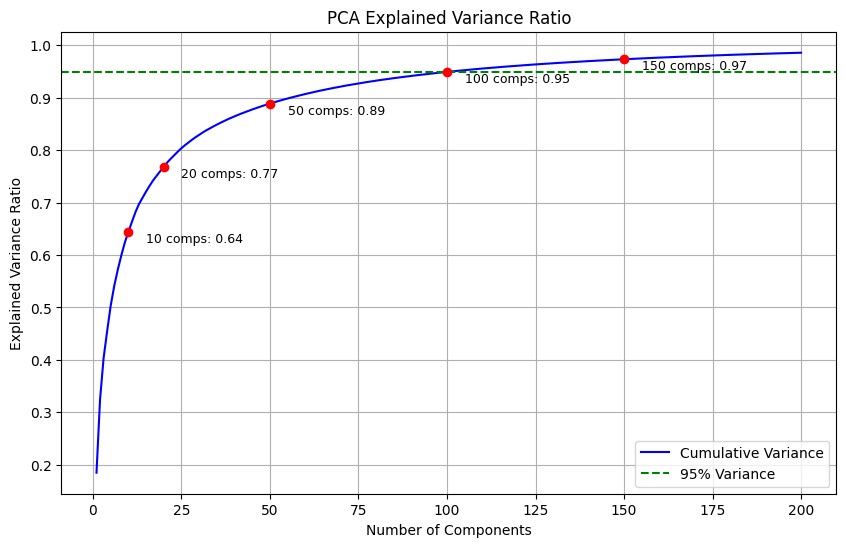

Fitting final PCA with n_components=100...
PCA Complete.


In [ ]:
# PCA
n_components_to_test = [10, 20, 50, 100, 150]
explained_variances = []

plt.figure(figsize=(10, 6))

# We need a temporary PCA to check variance for the max components we are interested in
pca_temp = PCA(n_components=200)
pca_temp.fit(X_train)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)

# Plot the curve
plt.plot(range(1, 201), cumulative_variance, label="Cumulative Variance", color="blue")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance Ratio")
plt.grid(True)

# Mark specific points
for n in n_components_to_test:
    var = cumulative_variance[n - 1]
    plt.scatter(n, var, color="red", zorder=5)
    plt.text(n + 5, var - 0.02, f"{n} comps: {var:.2f}", fontsize=9)
    print(f"Components: {n}, Explained Variance: {var:.4f}")

plt.axhline(y=0.95, color="g", linestyle="--", label="95% Variance")
plt.legend()
plt.savefig(f"{DIRS['figures']}/03_pca_variance_analysis.png")
plt.show()


best_n_components = 100

print(f"Fitting final PCA with n_components={best_n_components}...")
pca = PCA(n_components=best_n_components)
Z_pca_train = pca.fit_transform(X_train)
Z_pca_test = pca.transform(X_test)
Z_pca_val = pca.transform(X_val)  # Transform validation set too

# Save Results
joblib.dump(pca, f"{DIRS['models']}/pca_model.pkl")
np.save(f"{DIRS['data']}/Z_pca_train.npy", Z_pca_train)
np.save(f"{DIRS['data']}/Z_pca_test.npy", Z_pca_test)
np.save(f"{DIRS['data']}/Z_pca_val.npy", Z_pca_val)
print("PCA Complete.")

In [4]:
class AutoEncoder(models.Model):
    def __init__(self, input_dim, latent_dim=40):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = models.Sequential([
            layers.Dense(1024, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.2),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim, activation='linear', name='bottleneck') 
        ])
        
        # Decoder
        self.decoder = models.Sequential([
            layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1024, activation='relu'),
            layers.Dense(input_dim, activation='linear') # Reconstruction
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate
input_dim = X_train.shape[1] # 10304
model = AutoEncoder(input_dim, latent_dim=60)


c:\Users\Mueen\OneDrive\Desktop\Unsupervised_Final Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Hyperparameters
epochs = 200
batch_size = 128
learning_rate = 5e-4

# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss="mse")

# Train (Using X_train as both input and target for reconstruction)
print("Starting Autoencoder Training...")
history = model.fit(
    X_train,
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1,
)

# Save the full model
model.save_weights(f"{DIRS['models']}/autoencoder.weights.h5")

Starting Autoencoder Training...
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.1101 - val_loss: 0.3075
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - loss: 0.1150 - val_loss: 0.2357
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - loss: 0.0713 - val_loss: 0.2335
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 0.0677 - val_loss: 0.2127
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - loss: 0.0430 - val_loss: 0.2077
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - loss: 0.0402 - val_loss: 0.2031
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 0.0316 - val_loss: 0.1972
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step - loss: 0.0262 - val_loss: 0.1963
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - loss: 0.0226 - val_loss: 0.1926
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step - loss: 0.0194 - val_loss: 0.1912
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - loss: 0.0172 - val_loss: 0.1903
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━

Extracting compressed features...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


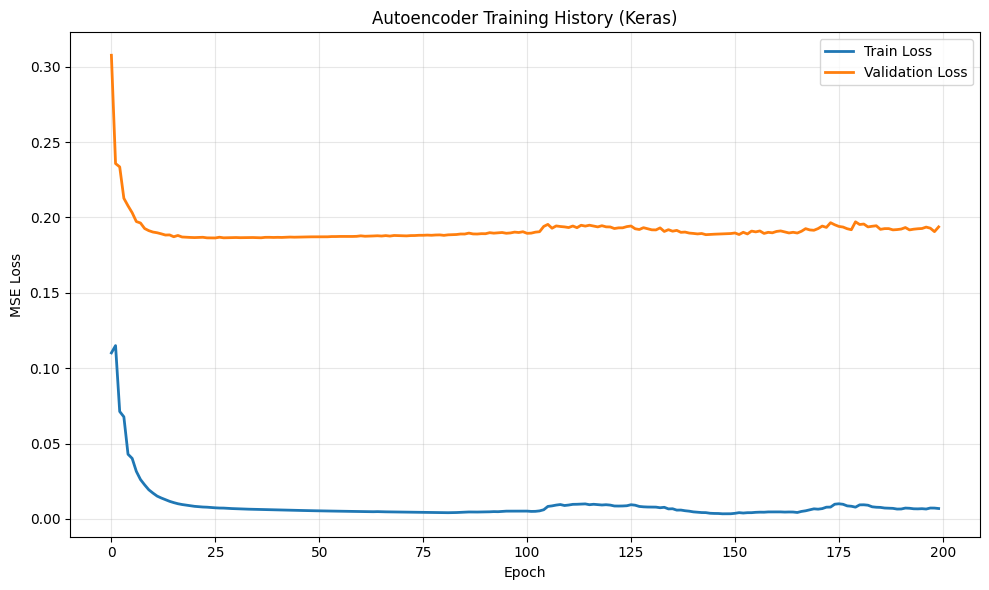

In [7]:
# Extract Features (Dimensionality Reduction)
print("Extracting compressed features...")
Z_ae_train = model.encoder.predict(X_train)
Z_ae_test = model.encoder.predict(X_test)

# Save Compressed Data
np.save(f"{DIRS['data']}/Z_ae_train.npy", Z_ae_train)
np.save(f"{DIRS['data']}/Z_ae_test.npy", Z_ae_test)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training History (Keras)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/03_ae_training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

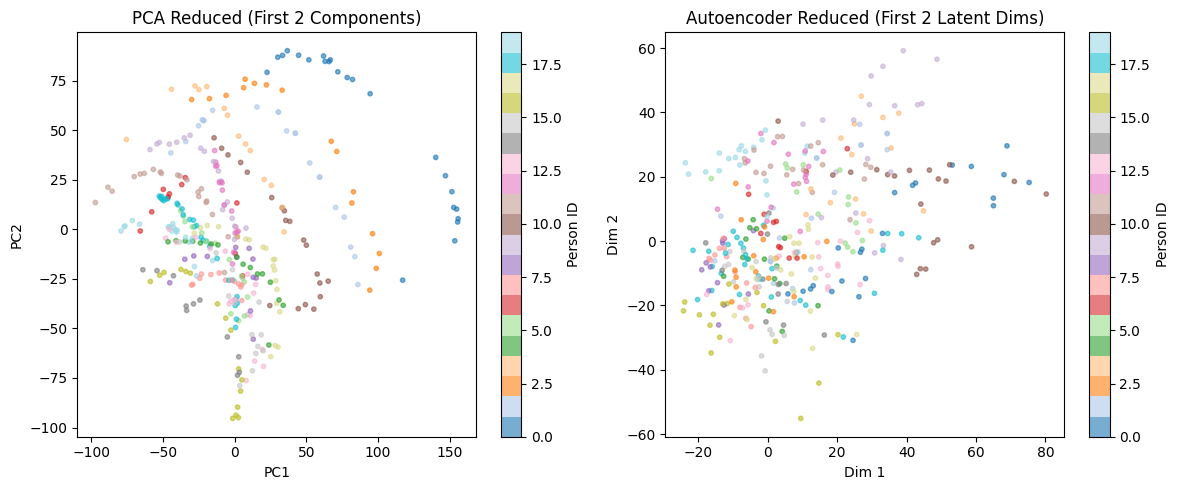

In [ ]:
# Visualize PCA and Autoencoder latent spaces in 2D by plotting their first two dimensions, colored by person ID, to compare how well they separate individuals.

y_train = np.load(f"{DIRS['data']}/y_train.npy")  # Need labels for coloring

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(
    Z_pca_train[:, 0], Z_pca_train[:, 1], c=y_train, cmap="tab20", s=10, alpha=0.6
)
plt.title("PCA Reduced (First 2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Person ID")

# Plot Autoencoder (First 2 dims of latent space)
plt.subplot(1, 2, 2)
plt.scatter(
    Z_ae_train[:, 0], Z_ae_train[:, 1], c=y_train, cmap="tab20", s=10, alpha=0.6
)
plt.title("Autoencoder Reduced (First 2 Latent Dims)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label="Person ID")

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/03_latent_space_scatter.png")
plt.show()